<a href="https://colab.research.google.com/github/mjhoover1/Robust_MAML/blob/main/Scratch_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torchmeta

In [4]:
import torchmeta
from torchmeta.utils.data import BatchMetaDataLoader
from torchvision.transforms import Compose, Resize, ToTensor


In [5]:
# dataset = torchmeta.datasets.MiniImagenet("data", num_classes_per_task=5, transform=Compose([ToTensor()]), meta_train=True,
# download=True)
# dataloader = BatchMetaDataLoader(dataset, batch_size=16, num_workers=4)
# print(dataset)

In [6]:
# from torchmeta.datasets.helpers import omniglot
# from torchmeta.utils.data import BatchMetaDataLoader

# dataset = omniglot("data", ways=5, shots=5, test_shots=15, meta_train=True, download=True)

# dataloader = BatchMetaDataLoader(dataset, batch_size=16, num_workers=4)

# for batch in dataloader:
#     train_inputs, train_targets = batch["train"]
#     print('Train inputs shape: {0}'.format(train_inputs.shape))    # (16, 25, 1, 28, 28)
#     print('Train targets shape: {0}'.format(train_targets.shape))  # (16, 25)

#     test_inputs, test_targets = batch["test"]
#     print('Test inputs shape: {0}'.format(test_inputs.shape))      # (16, 75, 1, 28, 28)
#     print('Test targets shape: {0}'.format(test_targets.shape))    # (16, 75)

In [7]:
import torch
import torch.nn as nn
from torchmeta.modules import (MetaModule, MetaSequential, MetaConv2d, MetaBatchNorm2d, MetaLinear)

def conv3x3(in_channels, out_channels):
  return MetaSequential(
      MetaConv2d(in_channels, out_channels, kernel_size=3, padding=1),
      MetaBatchNorm2d(out_channels, momentum=1., track_running_stats=False),
      nn.ReLU(),
      nn.MaxPool2d(2)
  )

class ConvolutionalNeuralNetwork(MetaModule):
  def __init__(self, in_channels, out_features, hidden_size=64):
    super(ConvolutionalNeuralNetwork, self).__init__()
    self.in_channels = in_channels
    self.out_features = out_features
    self.hidden_size = hidden_size

    self.features = MetaSequential(
        conv3x3(in_channels, hidden_size),
        conv3x3(hidden_size, hidden_size),
        conv3x3(hidden_size, hidden_size),
        conv3x3(hidden_size, hidden_size)
    )

    self.classifier = MetaLinear(hidden_size, out_features)

  def forward(self, inputs, params=None):
    features = self.features(inputs, params=self.get_subdict(params, 'features'))
    features = features.view((features.size(0), -1))
    logits = self.classifier(features, params=self.get_subdict(params, 'classifier'))
    return logits

In [8]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
import logging


from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters


def train(folder, device, num_shots=5, num_ways=5, batch_size=16, num_batches=100, num_workers=1, hidden_size=64, step_size=.4, first_order=True, output_folder=None):
  dataset = omniglot(folder, shots=num_shots, ways=num_ways, shuffle=True, test_shots=15, 
                    meta_train=True, download=True)
  dataloader = BatchMetaDataLoader(dataset, batch_size=batch_size, shuffle=True, 
                                  num_workers=num_workers)

  model = ConvolutionalNeuralNetwork(1, num_ways, hidden_size=hidden_size)
  model.to(device=device)
  model.train()
  meta_optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

  # Training loop
  with tqdm(dataloader, total=num_batches) as pbar:
    for batch_idx, batch in enumerate(pbar):

      model.zero_grad()

      train_inputs, train_targets = batch['train']
      train_inputs = train_inputs.to(device=device)
      train_targets = train_targets.to(device=device)

      test_inputs, test_targets = batch['test']
      test_inputs = test_inputs.to(device=device)
      test_targets = test_targets.to(device=device)
      
      outer_loss = torch.tensor(0., device=device)
      accuracy = torch.tensor(0., device=device)
      for task_idx, (train_input, train_target, test_input,
                     test_target) in enumerate(zip(train_inputs, train_targets,
                                                   test_inputs, test_targets)):
                       train_logit = model(train_input)
                       inner_loss = F.cross_entropy(train_logit, train_target)

                       model.zero_grad()
                       params = gradient_update_parameters(model,
                                                           inner_loss,
                                                           step_size=step_size,
                                                           first_order=first_order)
                       
                       test_logit = model(test_input, params=params)
                       outer_loss += F.cross_entropy(test_logit, test_target)

                       with torch.no_grad():
                         accuracy += get_accuracy(test_logit, test_target)
      outer_loss.div_(batch_size)
      accuracy.div_(batch_size)

      outer_loss.backward()
      meta_optimizer.step()

      pbar.set_postfix(accuracy='{0:.4f}'.format(accuracy.item()))
      if batch_idx >= num_batches: break

In [9]:
from collections import OrderedDict

def get_accuracy(logits, targets):
    """Compute the accuracy (after adaptation) of MAML on the test/query points

    Parameters
    ----------
    logits : `torch.FloatTensor` instance
        Outputs/logits of the model on the query points. This tensor has shape
        `(num_examples, num_classes)`.
    targets : `torch.LongTensor` instance
        A tensor containing the targets of the query points. This tensor has 
        shape `(num_examples,)`.
        
    Returns
    -------
    accuracy : `torch.FloatTensor` instance
        Mean accuracy on the query points
    """
    _, predictions = torch.max(logits, dim=-1)
    return torch.mean(predictions.eq(targets).float())

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:974: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


tensor(1)


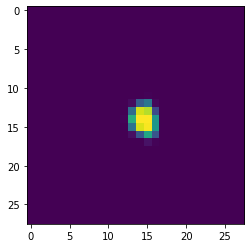

In [15]:
dataset = omniglot("data", shots=5, ways=5, shuffle=True, test_shots=15, 
                  meta_train=True, download=True)
dataloader = BatchMetaDataLoader(dataset, batch_size=16, shuffle=True, 
                                num_workers=1)

# test_image = test_inputs[0]
# test_image
# show_example(*test_image[0])

X = set()
for batch in dataloader:
  train_inputs, train_targets = batch["train"]
  show_example(*train_inputs[0][0])
  print(train_targets[0][0])
  break
  # for target in train_inputs:
  #   # print(target[0])
  #   print(*target[0].shape)
  #   show_example(*target[0])
  #   # s = set(target.tolist())
  #   # X = X.union(s)
  #   # print(X)

In [12]:
train("data", device)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:974: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}
{0, 1, 2

KeyboardInterrupt: ignored

In [10]:
for batch in dataloader:
    train_inputs, train_targets = batch["train"]
    print('Train inputs shape: {0}'.format(train_inputs.shape))    # (16, 25, 1, 28, 28)
    print('Train targets shape: {0}'.format(train_targets.shape))  # (16, 25)

    test_inputs, test_targets = batch["test"]
    print('Test inputs shape: {0}'.format(test_inputs))      # (16, 75, 1, 28, 28)
    print('Test targets shape: {0}'.format(test_targets.shape))    # (16, 75)


NameError: ignored

In [13]:
test_image = test_inputs[0]
test_image

NameError: ignored

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img):
    plt.imshow(img)

In [16]:
show_example(*test_image[0])

NameError: ignored

In [ ]:
test_targets[0][0]

In [ ]:
x = set()

In [ ]:
for batch in 

In [ ]:
X = set()
for batch in dataloader:
    train_inputs, train_targets = batch["test"]
    for target in train_targets:
      s = set(target.tolist())
      X = X.union(s)
      print(X)
    # print('Train inputs shape: {0}'.format(train_inputs.shape))    # (16, 25, 1, 28, 28)
    # print('Train targets shape: {0}'.format(train_targets.shape))  # (16, 25)

    # test_inputs, test_targets = batch["test"]
    # print('Test inputs shape: {0}'.format(test_inputs))      # (16, 75, 1, 28, 28)
    # print('Test targets shape: {0}'.format(test_targets.shape))    # (16, 75)

In [ ]:
x = set(train_targets[2].tolist())
# x = set(train_targets[2])

In [ ]:
x